# Basic example of latticeproteins

In [10]:
import latticeproteins as lp # envt is latticeproteins
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from helpers import *
from IPython.display import SVG, HTML
import multiprocessing as mp
import copy, random, pickle, secrets
!pwd

def set_random_seed(seed):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        print(f"Random seed set to {seed}")
    
def randomize_random_seed():
    # pick a system-random int (not affected by random.seed)
    sys_random_int = secrets.randbelow(100000)
    set_random_seed(sys_random_int)

def save_data(data, filenum=None):
    if filenum is None:
        filenum = random.randint(0, 99999)
    filename = f"run.{filenum:05d}.pkl"

    with open(filename, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Saved run to {filename}")
    return filenum

#filenum = save_data((args, lig_seq, founders))
#(args, lig_seq, founders) = load_data(filenum)

def load_data(filenum):
    filename = f"run.{filenum:05d}.pkl"
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data


/Users/mep/Repos/lab3


CLFRNERYSYAT URDRUULLLDD
Energy of native conformation: -21.160000
stability of native conformation: 1.378748
fraction folded: 0.201210


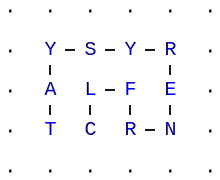

In [11]:
seq_length = 12
lattice = lp.thermodynamics.LatticeThermodynamics.from_length(seq_length, 1.0)
conf = None
while conf is None:
    seq = lp.random_sequence(seq_length)
    conf = lattice.native_conf(seq)
print("".join(seq), conf)

print("Energy of native conformation: %f" % lattice.nativeE(seq, target=conf))
print("stability of native conformation: %f" % lattice.stability(seq, target=conf))
print("fraction folded: %f" % lattice.fracfolded(seq, target=conf))
display(lp.draw.in_notebook(seq, conf).notebook)

Ligand: seq=QWNYVQ conf=UURDD
Energy of native conformation: -5.940000
stability of native conformation: 0.527441
fraction folded: 0.371114


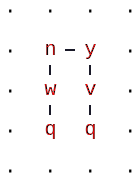

In [12]:
lig_length = 6
lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(lig_length, 1.0)

lig_conf = None
while lig_conf is None:
    lig_seq = lp.random_sequence(lig_length)
    lig_conf = lig_lattice.native_conf(lig_seq)
print(f"Ligand: seq={''.join(lig_seq)} conf={lig_conf}")
print("Energy of native conformation: %f" % lig_lattice.nativeE(lig_seq, target=lig_conf))
print("stability of native conformation: %f" % lig_lattice.stability(lig_seq, target=lig_conf))
print("fraction folded: %f" % lig_lattice.fracfolded(lig_seq, target=lig_conf))
display(lp.draw.in_notebook([x.lower() for x in lig_seq], lig_conf, color_sequence="r"*lig_length))

be: -8.870, xshift: -1, yshift: 4


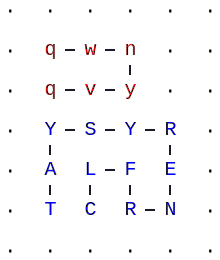

In [13]:
# bind the ligand to the protein

(be, xshift, yshift, lig_conf) = lp.conformations.BindLigand(seq, conf, lig_seq, lig_conf)
ligand_tup = (lig_seq, None, lig_conf, xshift, yshift) # the None is for ligand_color_seq
print(f"be: {be:0.3f}, xshift: {xshift}, yshift: {yshift}")


# save to .txt file
with open("bound_ligand.txt", "w", encoding="utf-8") as f:
    lp.conformations.PrintConformation(seq, conf, file = f, latex_format = False, ligand_tup = ligand_tup)

# save to .svg file
lp.draw.to_file(seq, conf, "bound_ligand.svg", ligand_tup=ligand_tup)

# display in notebook
lp.draw.in_notebook(seq, conf, ligand_tup=ligand_tup)

---
---

In [ ]:
# evolution!
 
seq_length = None
lig_length = None

def plot_prot_stats(args, prots):
    count_no_native = 0
    Elist, Slist, FoldFracList, Blist, FitList = [], [], [], [], []
    for prot in prots:
        seq = prot.seq
        conf = lattice.native_conf(seq)
    
        if conf is not None:
            (E, S, FF, be, fit) = get_fitness_etc(lattice, seq, conf, lig_seq, lig_conf)
            Elist.append(E)
            Slist.append(S)
            FoldFracList.append(FF)
            Blist.append(be)
            FitList.append(fit)
        else:
            print("No unique native conformation for seq:", seq)
            count_no_native += 1
            FitList.append(0.0)

    print(f"Number of sequences with no unique native conformation: {count_no_native}")
    plt.hist(FitList, bins=20)
    plt.xlabel("Fitness (BE * FF)")
    plt.ylabel("Count")
    plt.show()
   
def get_fitness_etc(lattice, seq, conf, lig_seq, lig_conf):
    assert conf is not None
    
    E = lattice.nativeE(seq, target=conf)
    S = lattice.stability(seq, target=conf)
    FF = lattice.fracfolded(seq, target=conf)
    (be, xshift, yshift, newconf) = lp.conformations.BindLigand(seq, conf, lig_seq, lig_conf)
    #fit = - be * FF # as in Bloom 2004
    fit = np.exp(-be) # as in Palmer 2013

    return (E, S, FF, be, fit)

# set up initial population from clones of founders
def make_clones(args, founders):
    prots = []
    copies = args.N // args.numClades
    #print(f"Making {copies} copies of each of {args.numClades} founders")
    for i, founder in enumerate(founders):
        for _ in range(copies):
            prot = Prot(args, clade_idx=founder.clade_idx, parent_idx=None, seq=founder.seq)
            prot.compute_fitness(lig_seq, lig_conf)
            prots.append(prot)
    return prots

class Prot():
    global_idx = 0 # class variable to give each Prot a unique index

    def __init__(self, args, clade_idx, parent_idx, seq=None):
        self.args = args
        self.seq_length = args.seq_length
        if self.seq_length != self.args.lattice.conformations._length:
            raise ValueError(f"Prot seq_length {self.seq_length} does not match lattice length {lattice.confs._length}")
        if seq is None: # pick a random sequence
            conf = None
            while conf is None:
                if True:
                    FF = 0.0
                    while FF < args.minFoldFrac:
                        seq = lp.random_sequence(args.seq_length)
                        FF = args.lattice.fracfolded(seq)
                        #print(f"Trying seq {''.join(seq)} with FoldFrac {FF:0.3f} need {args.minFoldFrac}")
                    (minE, conf, partitionsum, folds) = self.args.lattice._nativeE(seq)
                else:
                    minE = 999
                    while minE >= -25:
                        seq = lp.random_sequence(args.seq_length)
                        (minE, conf, partitionsum, folds) = self.args.lattice._nativeE(seq)
            print(f"Chose seq:{''.join(seq)} with minE:{minE:0.3f} FoldFrac:{FF:0.3f} conf:{conf}")
        else: # use the provided sequence
            (minE, conf, partitionsum, folds) = self.args.lattice._nativeE(seq)
            #if conf is None:
            #    print("Warning: created Prot with no unique native conformation for seq:", seq)

        self.seq = seq
        self.conf = conf # might be None if no unique native conf
        self.minE = minE
        self.fit = None
        self.clade_idx = clade_idx # index of the original founding ancestor Prot
        self.parent_idx = parent_idx # index of the immediate parent Prot. Founders have parent_idx = None
        
        # give each created Prot a unique index
        self.idx = Prot.global_idx
        Prot.global_idx += 1
        
    def __repr__(self):
        (E, S, FF, be, fit) = get_fitness_etc(self.args.lattice, self.seq, self.conf, lig_seq, lig_conf)
        str = ""
        str += f"  Prot({self.idx}: clade={self.clade_idx}, parent={self.parent_idx}, seq={''.join(self.seq)}, conf={self.conf}\n"
        str += f"  Energy:{E:.2f} Stability:{S:.2f} Fraction folded:{FF:.2f} Binding energy:{be:.2f} Fitness:{fit:.2f}"
        return str

    def display(self):    
        display(lp.draw.in_notebook(self.seq, self.conf).notebook)
        
    def compute_fitness(self, lig_seq, lig_conf):
        if self.conf is None:
            fit = 0.0
        else:
            if True: # use Palmer 2013 fitness function
                (be, xshift, yshift, newconf) = lp.conformations.BindLigand(self.seq, self.conf, lig_seq, lig_conf)
                fit = np.exp(-be) # as in Palmer 2013
            else: # use Bloom 2004 fitness function
                FF = self.args.lattice.fracfolded(self.seq, target=self.conf)
                (be, xshift, yshift, newconf) = lp.conformations.BindLigand(self.seq, self.conf, lig_seq, lig_conf)
                #fit = max(0.0, - be * FF)  # as in Bloom 2004
                fit = max(0.0, FF * np.exp(-be)) # other
        self.fit = fit
        return fit
    
    def mutate(self):
        newseq = lp.sequences.mutate_sequence(self.seq, self.args.mu) #/self.args.seq_length)
        return Prot(self.args, clade_idx=self.clade_idx, parent_idx=self.idx, seq=newseq)

def one_gen(args, prots, lig_seq, lig_conf):
    # selection
    rawfits = np.array([prot.compute_fitness(lig_seq, lig_conf) for prot in prots])

    fits = rawfits.copy()
    #print("fits1:", fits)
    if True:
        minFit = np.min(fits)
        fits = fits - minFit # shift so min is zero
        fits += args.softFit # add softfit to avoid zero fitnesses
    sum_fit = np.sum(fits)
    fits = fits / sum_fit
    #print("fits2:", fits)
    
    # reproduction
    offspring = binom.rvs(n=round(args.N), p=fits)
    #print("offspring:", offspring)
    new_prots = []
    for i, prot in enumerate(prots):
        for _ in range(offspring[i]):
            new_prots.append(prot.mutate())
            
    return new_prots, fits, rawfits

def one_run(args, founders, lig_seq, lig_conf):
    prots = make_clones(args, founders)

    avgFitList = []
    clades = [DotAccessibleDict({'counts': []}) for _ in range(args.numClades)]
    for i in range(args.maxGen):
        # record counts of each clade for this generation
        cladeList = [prot.clade_idx for prot in prots]
        for cl in range(args.numClades):
            cnt = cladeList.count(cl)
            clades[cl].counts.append(cnt)
            
        # if i%1==0:
        #     print(f"\n=== Generation {i} ===")
        #     plot_prot_stats(args, prots)
        prots, fits, rawfits = one_gen(args, prots, lig_seq, lig_conf)
        avgFit = np.mean(rawfits)
        avgFitList.append(avgFit)
        
    #print(f"\n=== Generation {i} ===")
    #plot_prot_stats(args, prots)
    
    return prots, clades, avgFitList 

def plot_kfit(args, runs):
    N, numClades, numRuns, maxGen = \
        args.N, args.numClades, args.numRuns, args.maxGen

    strN = N#f"{e_format(N)}"
    xlog, ylog = args.plotLog, args.plotLog
    ylog = False
    lw, lsA, lsB = 1, "-", "--"
    colors = "rgbm"
    markers = "+x*s"

    # compute and plot fit, surv, surprisal for each clade, at each time, averaged over runs
    # fitness stats are for entire clades, not types. Because we might start with 0 of any type
    labels = []
    handles = []

    for run in runs:
        prots, clades, avgFitList = run
        for idx2, clade in enumerate(clades):
            clade.fit = np.array(clade.counts) / clade.counts[0]  # fitness (i.e., relative to initial count) for clade idx2 in pop idx over t
            clade.surv = np.array([1.0 if x>0 else 0.0 for x in clade.counts]) # survival for clade idx2 in pop idx over t

    #sumClades = [DotAccessibleDict({'avgFit': np.zeros(maxGen), 'avgSurv': np.zeros(maxGen), 'surprisal': np.zeros(maxGen)})  for _ in range(numClades)]
    sumClades = [DotAccessibleDict()  for _ in range(numClades)]
    # now 1) get the survival p's for all runs in one place, and 2) compute across-run avgFit, avgSurv, surprisal per clade
    allp = np.zeros((numClades, numRuns, maxGen))
    for idx2, sumClade in enumerate(sumClades):
        sumClade.avgFit = np.zeros(maxGen)
        sumClade.avgSurv = np.zeros(maxGen)
        for r in range(numRuns):
            clade_r = runs[r][1][idx2]
            sumClade.avgFit += clade_r.fit
            sumClade.avgSurv += clade_r.surv
            allp[idx2][r] = clade_r.surv # the prob that clade idx2 survives at time t in run r
        sumClade.avgFit /= float(numRuns)
        sumClade.avgSurv /= float(numRuns)
        sumClade.surprisal = -sumClade.avgSurv*np.log2(sumClade.avgSurv + 1e-12) - (1.0 - sumClade.avgSurv)*np.log2(1.0 - sumClade.avgSurv + 1e-12)
        
    # from allp, compute joint surprisal over all joint clade survival states
    joint_surprisal = np.zeros(maxGen)
    numStates = 2**numClades
    for t in range(maxGen):
        joint_surv = np.zeros(numStates) # for this whole pop at time t
        for state in range(numStates):
            prob = 1.0 # will hold the probability of this joint state at time t
            for idx2, sumClade in enumerate(sumClades):
                if (state >> idx2) & 1: # clade idx2 survives in this state
                    prob = prob * allp[idx2][:, t] # the prob that clade idx2 survives at time t in all runs
                else: # clade idx2 does NOT survive in this state
                    prob = prob * (1.0 - allp[idx2][:, t]) # the prob that clade idx2 does NOT survive at time t in all runs
            joint_surv[state] = np.mean(prob) # average over runs
        joint_surprisal[t] = -np.sum(joint_surv * np.log2(joint_surv + 1e-12)) 

    # now plot the avg fit (left axis) and surv (right axis) data, with one row for each pop
    fig, axes = plt.subplots(1, 3, layout='constrained', figsize=(3*4.0, 4.0)) #numPops*4.0)) # Adjust figsize as needed
    fig.suptitle(f"N={strN}"+f" ({numRuns} runs)" if numRuns>1 else "")

    ax1, ax2, ax3 = axes[0], axes[1], axes[2]
    lw = 1
    lsA = "-"
    lsB = "--"
    for idx2, sumClade in enumerate(sumClades): # each clade in each pop
        # Fixed colors: M2 is red, M3 is green, M4 is blue, M5 is magenta, M6 is cyan, M7 is orange, 
        # darker shade for allele A, lighter shade for allele B
        #shades = [scale_lightness(colors[idx2], scale) for scale in [0.5, .75, 1., 1.25, 1.5]]
        h = ax1.plot(sumClade.avgFit, color=colors[idx2], marker=markers[idx2], ms=3, lw=0.5, markerfacecolor='none')[0] # note [0]
        handles.append(h)
        labels.append(f"{idx2}")
        ax2.plot(sumClade.avgSurv, color=colors[idx2], marker=markers[idx2], ms=3, lw=0.5, markerfacecolor='none')
        ax3.plot(sumClade.surprisal, color=colors[idx2], marker=markers[idx2], ms=3, lw=0.5, markerfacecolor='none')
    # plot joint surprisal
    joint_h = ax3.plot(joint_surprisal, color='#000000', linestyle=':', marker="+", ms=2, linewidth=0.5, markerfacecolor='none', label='joint')[0]

    ax1.set_ylabel("W_k(0)")
    ax2.set_ylabel("S_k(0)")
    ax3.set_ylabel("H(k)")
        
    #ax1.tick_params(labelbottom=False)
    #ax2.tick_params(labelbottom=False)
    #ax3.tick_params(labelbottom=False)
    ax1.locator_params(axis='x', nbins=5)  # just put 5 major tics
    ax2.locator_params(axis='x', nbins=5)  # just put 5 major tics
    ax3.locator_params(axis='x', nbins=5)  # just put 5 major tics
    ax1.set_xlabel("generation (k)")
    ax2.set_xlabel("generation (k)")
    ax3.set_xlabel("generation (k)")

    if xlog:
        ax1.set_xscale("log", nonpositive='mask')
        ax2.set_xscale("log", nonpositive='mask')
        ax3.set_xscale("log", nonpositive='mask')
    if ylog:
        ax1.set_yscale("log", nonpositive='mask')
        
    ax2.set_ylim(-0.05, 1.05)
    ax3.set_ylim(-0.05, numClades)
                
    plt.xlabel("generation (k)")

    ax1.legend(handles=handles, labels=labels,
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                fancybox=True, shadow=True, ncol=1, borderaxespad=0.0)
    ax2.legend(handles=handles, labels=labels,
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                fancybox=True, shadow=True, ncol=1, borderaxespad=0.0)
    handles.append(joint_h)
    labels.append(f"joint")
    ax3.legend(handles=handles, labels=labels,
                loc='center left', bbox_to_anchor=(1.02, 0.5),
                fancybox=True, shadow=True, ncol=1, borderaxespad=0.0)

    #plt.savefig(f"output/plotk.png", dpi=300)
    plt.show()
    
def plot_counts(args, runs):
    # now, for each clade, average counts over runs
    numClades = args.numClades
    clades = [DotAccessibleDict({'counts': np.zeros(args.maxGen)}) for
                _ in range(numClades)]
    for run in runs:
        run_clades = run[1]
        for idx2, clade in enumerate(run_clades):
            clades[idx2].counts += np.array(clade.counts)
    for clade in clades:
        clade.counts /= float(len(runs))

    # plot counts of each clade over generations
    plt.figure(figsize=(8,4))

    gens = list(range(args.maxGen))
    if args.plotLog:
        plt.xscale('log')
        #plt.yscale('log')
        gens = gens[1:] # skip generation 0 to avoid log(0)

    colors = "rgbm"
    markers = "+x*s"
    for cl, clade in enumerate(clades):
        if args.plotLog:
            counts = clade.counts[1:] # skip generation 0 to avoid log(0)
        else:
            counts = clade.counts
        plt.plot(gens, counts, ms=3, markerfacecolor='none', lw=0.5, label=f"{cl}", color=colors[cl], marker=markers[cl])
        
    plt.xlabel("Generation")
    plt.ylabel("Count")
    plt.title("Clade counts over generations")
    # show only 10 xticks evenly spaced across the whole x axis
    if not args.plotLog:
        ticks = np.linspace(gens[0], gens[-1]+1, 11, dtype=int)
        plt.xticks(ticks)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_rawfit(args, runs):
    sumFitList = np.array(runs[0][2])
    for run in runs[1:]:
        avgFitList = np.array(run[2])
        sumFitList += avgFitList
    avgFitList = sumFitList / float(len(runs))
        
    # plot avgFitList
    plt.figure(figsize=(6,4))
    plt.plot(range(args.maxGen), avgFitList, marker='o', ms=3, lw=1)
    if args.plotLog:
        plt.xscale('log')
    plt.xlabel("Generation")
    plt.ylabel("Average fitness")
    plt.title("Average fitness over generations")
    plt.grid(alpha=0.3)
    plt.show()
    
def show_representative_proteins(args, runs, lig_seq, lig_conf):
    # show representative protein from each clade in first run, with ligand bound
    run = runs[0]
    prots = run[0]
    for clade_idx in range(args.numClades):
        # pick the first prot you find with this clade_idx
        seq = None
        for prot in prots:
            if prot.clade_idx == clade_idx:
                seq = prot.seq
                conf = prot.conf
                break
        if seq is None:
            print(f"No prot found for clade {clade_idx}")
            continue
        print(f"Clade {clade_idx} representative protein:\n{prot}")
        (be, xshift, yshift, new_conf) = lp.conformations.BindLigand(seq, conf, lig_seq, lig_conf)
        ligand_tup = (lig_seq, None, lig_conf, xshift, yshift) # the None is for ligand_color_seq
        print(f"be: {be:0.3f}, xshift: {xshift}, yshift: {yshift}")
        display(lp.draw.in_notebook(seq, conf, ligand_tup=ligand_tup))

###### Main script ####    

args = DotAccessibleDict({'seq_length': 12, 'lig_length': 6, 'minFoldFrac': 0.9, 'N': 16384, 'numClades': 4, 'mu': 0.0005, 'softFit': 0.1,
                        'numRuns': 16, 'maxGen':100, 'plotLog': True})

print("args:", args, "\n")

# set a random seed for reproducibility
set_random_seed(43)

if True:
    # HACK - use ligand and founding proteins from Palmer et al. 2013
    args.lig_length = 6 # override
    lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.lig_length, 1.0)
    lig_seq = 'LIVKRS'
    lig_conf = lig_lattice.native_conf(lig_seq)

    args.seq_length = 12 # override
    args.numClades = 4 # override
    args.lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.seq_length, 1.0)
    founders = []
    founders.append(Prot(args, clade_idx=0, parent_idx=None, seq='FCTFKIINCEWV'))
    founders.append(Prot(args, clade_idx=1, parent_idx=None, seq='MVNLTLFSVTLM'))
    founders.append(Prot(args, clade_idx=2, parent_idx=None, seq='FLELTCLNNPCF'))
    founders.append(Prot(args, clade_idx=3, parent_idx=None, seq='IWPKAHMLSHNY'))
else:
    # random ligand
    lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.lig_length, 1.0)
    lig_conf = None
    while lig_conf is None:
        lig_seq = lp.random_sequence(args.lig_length)
        lig_conf = lig_lattice.native_conf(lig_seq)

    # random founders
    args.lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.seq_length, 1.0)
    founders = [Prot(args, clade_idx=clade_idx, parent_idx=None) for clade_idx in range(args.numClades)]

if True: # print initial setup
    # print ligand
    print(f"\nLigand:\n  seq={''.join(lig_seq)} conf={lig_conf}")
    E, S, FF, be, fit = get_fitness_etc(lig_lattice, lig_seq, lig_conf, lig_seq, lig_conf)
    print(f"  Energy:{E:.2f} Stability:{S:.2f} Fraction folded:{FF:.2f}")
    display(lp.draw.in_notebook([x.lower() for x in lig_seq], lig_conf, color_sequence="r"*args.lig_length))

    # print founder proteins
    print("Founders:")
    for idx, prot in enumerate(founders):
        print(prot, flush=True)
        prot.display()

runs = []
if 1:
    # evolve multiple runs in parallel
    ctx = mp.get_context('fork')
    with ctx.Pool() as pool:
        args_list = [(args, founders, lig_seq, lig_conf) for _ in range(args.numRuns)]
        # one_run signature: one_run(args, founders, lig_seq, lig_conf)
        runs = pool.starmap(one_run, args_list)
        oldruns = copy.deepcopy(runs)
else:
    runs = copy.deepcopy(oldruns)       

# plot results
plot_rawfit(args, runs)
plot_kfit(args, runs)

show_representative_proteins(args, runs, lig_seq, lig_conf)